Bayesian Thinking
<html>
    <summary></summary>
         <div> <p></p> </div>
         <div style="font-size: 20px; width: 800px;"> 
              <h1>
               <left>Bayesian Thinking</left>
              </h1>
              <p><left>============================================================================</left> </p>
<pre>Course: BIOM 421, Spring 2024
Instructor: Brian Munsky
Authors: Drs. Kaan Öcal, Huy Vo, Brian Munsky
Contact Info: munsky@colostate.edu
</pre>
         </div>
    </p>

</html>

<details>
  <summary>Copyright info</summary>

```
Copyright 2024 Brian Munsky

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>



In [2]:
# @title Importing packages
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm        # progress bars

## Introduction

In this lecture we will learn how to perform Bayesian inference in practice to estimate model parameters from data. This will involve most of the things we learned in the course so far, as well as a new technique, Markov Chain Monte Carlo (MCMC). MCMC is the current state-of-the-art approach to deal with complicated probability distributions, and as a result it is one of the cornerstones of modern scientific computing. Our goal in this module is to understand the idea behind MCMC, to apply it to a simple example or two, and to combine it with the Chemical Master Equation to do some inference.

## Contents
1. Review of Bayesian inference
2. Monte Carlo methods
3. Markov Chains
4. Markov Chain Monte Carlo (MCMC)

Before tackling this lecture, we highly recommend the video ["Bayes theorem, the geometry of changing beliefs"](https://www.youtube.com/watch?v=HZGCoVF3YvM) by 3Blue1Brown, as much of the motivation for MCMC comes from Bayesian inference (or statistical mechanics, for the physics aficionados).

# 1. Review of Bayesian inference

## Why Bayesian inference?

Biological experiments are often slow and costly, and due to the delicate nature of living cells we cannot directly measure many of the things we care about. And when we do manage to measure them, these measurements are often subject to a lot of noise - we saw this in our analysis of smFISH microscopy images. If we want to study biology, therefore, we need to be careful about the conclusions we draw given imperfect data. Bayesian statistics provides a general framework that allows us to deal with the noise and uncertainty we encounter in practice.

The workhorse of Bayesian inference is **Bayes' Theorem**:

$$ p(x \, | \, \mathcal{Data}) = \frac {p(\mathcal{Data} \, | \, x) \, p(x)}{p(\mathcal{Data})} $$

Here $x$ is quantity that we wish to infer, and $\mathcal{Data}$ is our data. Bayes' Theorem tells us how observing $\mathcal{Data}$ affects our knowledge of the true quantity $x$, based on our prior knowledge of $x$ represented by the prior $p(x)$, and the predictions of the model, represented by the likelihood $p(\mathcal{Data} \, | \, x)$. 

The normalising constant in the denominator of Bayes' Theorem is required to ensure that the posterior probabilities over $x$ sum to $1$. The posterior is meaningless without this. The normalising constant can be explicitly written as

$$ p(\mathcal{Data}) = \int p(\mathcal{Data} \, | \, x) \, p(x) \, dx $$

The normalization constant is an integral of the probability of the observed data over *all* possible values of $x$.  In other words, this is the total probability that we would observe the data under *any* possible model explanation. The reason for this normalization constant is that, in order for us to know whether a specific model (i.e., $x$) is a good explanation of our data, we need to consider how well that explanation performs relative to all other possible explanations that could have given the same data.

To summarize the elements of the Bayes' Theorem (remember and understand this!!)
* $x$ = quantity that we wish to infer,
* $p(x)$ = our **prior** knowledge of $x$ before doing the experiment.
* $\mathcal{Data}$ = our data or **evidence**.
* $p(\mathcal{Data} \, | \, x)$ == our model predictions or **likelihood function**.
* $p(\mathcal{Data})$ = the **normalization constant**.

# Example 1 - Librarians and Farmers
In [3Blue1Brown's video on Bayes' theorem](https://www.youtube.com/watch?v=HZGCoVF3YvM) you will meet Steve, and you will be given four facts:
 
 1) Steve is shy and withdrawn, 
 2) 40% of librarians are shy and withdrawn
 3) 10% of Farmers are shy and withdrawn
 4) There are 20 times as many farmers as there are librarians
 5) (assumed) Steve is know to be either a farmer or a librarian.
 
How would you guess if Steve is a Librarian or a Farmer?

What do you think the probability is that Steve is a Librarian?

How do you rationally answer these questions.

In [5]:
# Let's define the variables of our problem:

P_data_given_librarian = 0.4
P_data_given_farmer = 0.6
P_prior_librarian = 1/(1 + 20)
P_prior_farmer = 1 - P_librarian

# Now we can calculate the probability of the data given the model:
P_shy_and_withdrawn = P_data_given_librarian*P_prior_librarian + P_data_given_farmer*P_prior_farmer

# And the probability of the model given the data:
P_librarian_given_data = P_data_given_librarian*P_prior_librarian/P_shy_and_withdrawn
P_farmer_given_data = P_data_given_farmer*P_prior_farmer/P_shy_and_withdrawn

print(f"The probability that Steve is a Librarian is {P_librarian_given_data:.2f}")
print(f"The probability that Steve is a Farmer is {P_farmer_given_data:.2f}")

The probability that Steve is a Librarian is 0.03
The probability that Steve is a Farmer is 0.97


# Example 2 - COVID Test
According to [Cochrane](https://www.cochrane.org/CD013705/INFECTN_how-accurate-are-rapid-antigen-tests-diagnosing-covid-19) I found that at home rapid antigen tests have the following statistics:
 
 1) The probability of a false negative is 18%.
 2) The probability of a true positive is 92%.
 3) The probability of a false positive is 0.4%.
 4) The probability of a true negative is 99.6%.

Let's assume that about 5% of people are infected at the current time.

If you take a test and get a positive, what is the probaiblity that you have COVID?

If you take a test and get a positive, what is the probaiblity that you have COVID?

In [9]:
# Define the variables of our problem:
P_positive_given_covid = 0.92
P_negative_given_covid = 0.08
P_positive_given_no_covid = 0.08
P_negative_given_no_covid = 0.92
P_prior_covid = 0.05
P_prior_no_covid = 1 - P_prior_covid

# Calculate the probability of the data given the model:
P_positive = P_positive_given_covid*P_prior_covid + P_positive_given_no_covid*P_prior_no_covid
P_negative = P_negative_given_covid*P_prior_covid + P_negative_given_no_covid*P_prior_no_covid

# Calculate the probability of the model given the data:
P_covid_given_positive = P_positive_given_covid*P_prior_covid/P_positive
P_covid_given_negative = P_negative_given_covid*P_prior_covid/P_negative

print(f"The probability that a person has Covid given a positive test is {P_covid_given_positive:.2f}")
print(f"The probability that a person has Covid given a negative test is {P_covid_given_negative:.2f}")

The probability that a person has Covid given a positive test is 0.38
The probability that a person has Covid given a negative test is 0.00


## **Example 3:** Flipping coins

*In this example, we are going to move away from the binary (yes/no) problem and try to estimate a parameter on the real line.*

We can visualise the Bayesian approach for parameter estimation using a simple coin example. Suppose that I have a coin which has a fixed probability $h$ to land on heads each time it is flipped. How much can we say about $h$ by observing how the coin behaves? We flip the coin $8$ times and observe the sequence $H, H, H, H, T, H, H, H$.

Let us analyse the individual parts in Bayes' Theorem for this example:
1. **The prior $p(h)$:** We assume the coin is fair, but allow for the possibility of a biased coin. Our prior should be peaked at $h = \frac 1 2$, but allow all values between $0$ and $1$. A convenient probability distribution for numbers between $0$ and $1$ is the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution):

$$ p(h) = \textrm{Beta}(h; 4, 4) $$

2. **The likelihood $p(\mathcal{Data}  \, | \, h)$:** Each flip has a probability $h$ to land on heads, independently of the others. We can write down the likelihood explicitly:
$$ p(\mathcal{Data} \, | \, h) = h^7 (1-h) $$
(Please note -- this is the likelihood of the sequence in its known order. If the data were unordered (i.e., 7 heads and one tails but in an unknown order), you would need to use the Binomial distribution.)

3. **The posterior $p(h \, | \, \mathcal{Data})$:** In this example, a little bit of maths allows us to compute this explicitly. We will later see how to do this using MCMC.

In the exercises you will be asked to compute the posterior, which requires knowing the normalisation constant $p(\mathcal{Data})$. Even for this simple example, computing the normalisation constant is not trivial!

In [ ]:
#Estimating the fairness of a coin based on repeated coin flips
data_ct = [ 1, 1, 1, 1, 0, 1, 1, ]  # 1 for heads, 0 for tails
n_heads = np.sum(data_ct)

# Prior for the coin toss example
def prior_ct(h):
  return sp.stats.beta(4,4).pdf(h)

# Likelihood function
def likelihood_ct(data, h):
  n_heads = sum(data)
  n_tails = len(data) - n_heads

  return h ** n_heads * (1-h) ** n_tails

# Posterior
# We will ignore the normalisation constant for now; it does not appear in the plot
def posterior_unnormalised_ct(h, data):
  return likelihood_ct(data, h) * prior_ct(h)

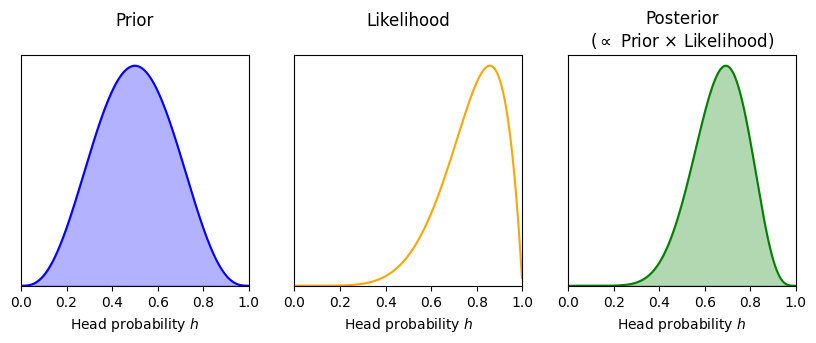

In [ ]:
#@title
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(10,3))

xx = np.arange(0, 1, 0.002)

# Plot prior
axes[0].plot(xx, prior_ct(xx), color="blue")
axes[0].fill_between(xx, 0, prior_ct(xx), color="blue", alpha=0.3)
axes[0].set_title("Prior\n")
axes[0].set_xlabel("Head probability $h$")
axes[0].set_yticks([])
axes[0].set_ylim(bottom=0)

# Plot likelihood
axes[1].plot(xx, likelihood_ct(data_ct, xx), color="orange")
axes[1].set_title("Likelihood\n")
axes[1].set_xlabel("Head probability $h$")
axes[1].set_yticks([])
axes[1].set_ylim(bottom=0)

# Plot the (unnormalised) posterior
axes[2].plot(xx, posterior_unnormalised_ct(xx, data_ct), color="green")
axes[2].fill_between(xx, 0, posterior_unnormalised_ct(xx, data_ct), color="green", alpha=0.3)
axes[2].set_title("Posterior\n($\propto$ Prior $\\times$ Likelihood)")
axes[2].set_xlabel("Head probability $h$")
axes[2].set_yticks([])
axes[2].set_ylim(bottom=0)
axes[2].set_xlim(0, 1);

## **Example 4:** Gene expression

Consider a bacterial gene $G$ that produces mRNA $M$ at a fixed but unknown rate $\sigma$. mRNA typically gets degraded at a fixed rate $d$ that can be measured directly; in this example, the degradation rate is measured to be about $d = 0.5/\textrm{h}$.

$$ G \longrightarrow G + M \qquad\qquad M \rightarrow \emptyset $$

We want to infer the production rate $\sigma$ by measuring gene expression in 30 cells using an smFISH experiment. After the experiments have been performed, the data looks like this:

In [ ]:
data_ge = [ 20, 20, 19, 16, 15, 22, 17, 27, 17, 17, 21, 21, 16, 22, 25, 22, 23,
            20, 21, 16, 16, 18, 16, 21, 17, 21, 25, 16, 15, 23 ]

deg = 0.5     # degradation rate

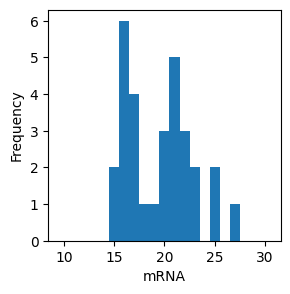

In [ ]:
#@title
fig, ax = plt.subplots(figsize=(3,3))

ax.hist(data_ge, bins=21, range=(9.5, 30.5))

ax.set_xlabel("mRNA")
ax.set_ylabel("Frequency");

Let us review the individual parts in Bayes' Theorem for this example.
1. **The prior $p(\sigma)$:** Bacteria tend to be small and express only few mRNA molecules. A realistic production rate could be about $5/\mathrm{h}$, but this depends on the gene. For our prior we choose an exponential distribution with mean $5$:

$$ p(\sigma) = \textrm{Exp}(\sigma; 1/5) $$

2. **The likelihood $p(\mathcal{Data}  \, | \, \sigma)$:** The cells have been kept in the lab for a while, so we assume that mRNA production has reached steady state. At steady state, mRNA counts for this model are Poisson distributed with mean $\sigma / d$:
$$ p(n \, | \, \sigma) = \textrm{Poisson}(n; \sigma / d) $$
  Here $n$ is the number of mRNA measured. The total likelihood is just the product of the likelihoods for each individual cell, since we assume that each cell is independent of the others:

$$ p(\mathcal{Data} \, | \, \sigma) = \prod_{i=1}^{30} \textrm{Poisson}(n_i; \sigma / d) $$

3. **The posterior $p(\sigma \, | \, \mathcal{Data})$:** In this example we can still compute this explicitly. This won't be possible for more complex models of gene expression. The difficulty here is again the normalisation constant.

**Important:** In the Bayesian setting we have to decide the prior *before* looking at the data. The data only comes in via Bayes' formula.

In [ ]:
# @title Estimating the fairness of a coin based on repeated coin flips
# Prior for the gene expression model
def prior_ge(h):
  return sp.stats.gamma(1, scale=5).pdf(h)

# Likelihood
def likelihood_ge(data, sigma):
  ret = 1
  for n in data:
    ret *= sp.stats.poisson(sigma / deg).pmf(n)

  return ret

# Posterior (unnormalised, again)
def posterior_unnormalised_ge(h, data):
  return likelihood_ge(data, h) * prior_ge(h)

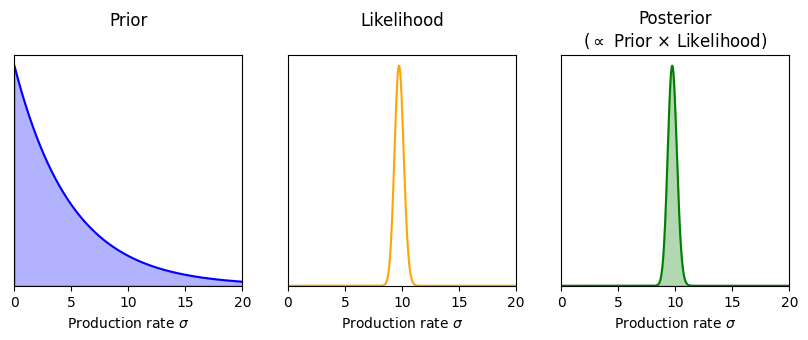

In [ ]:
#@title
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(10,3))

xx = np.arange(0, 20, 0.01)

# Plot the prior
axes[0].plot(xx, prior_ge(xx), color="blue")
axes[0].fill_between(xx, 0, prior_ge(xx), color="blue", alpha=0.3)
axes[0].set_title("Prior\n")
axes[0].set_xlabel("Production rate $\sigma$")
axes[0].set_yticks([])
axes[0].set_ylim(bottom=0)

# Plot the likelihood
axes[1].plot(xx, likelihood_ge(data_ge, xx), color="orange")
axes[1].set_title("Likelihood\n")
axes[1].set_xlabel("Production rate $\sigma$")
axes[1].set_yticks([])
axes[1].set_ylim(bottom=0)

# Plot the posterior
axes[2].plot(xx, posterior_unnormalised_ge(xx, data_ge), color="green")
axes[2].fill_between(xx, 0, posterior_unnormalised_ge(xx, data_ge), color="green", alpha=0.3)
axes[2].set_title("Posterior\n($\propto$ Prior $\\times$ Likelihood)")
axes[2].set_xlabel("Production rate $\sigma$")
axes[2].set_yticks([])
axes[2].set_ylim(bottom=0)
axes[2].set_xlim(0, 20);

We see that the posterior is tightly peaked around $10$, which suggests that we have enough data to make confident estimates of $\sigma \approx 10 \pm 1$.

<!-- This simple example showcases the main aspects of Bayesian inference: choosing a prior, computing the likelihood, and computing the posterior.  -->

## Bayesian inference in practice

In both examples we could use Bayes' theorem to explicitly compute the posteriors (see exercises below). In practice we often encounter more complex models, and each of the three terms in Bayes' formula can cause headaches.
1. **The prior $p(x)$:** We usually don't know much about $x$ before collecting data, but we need to choose a prior distribution. Sometimes it's not obvious what prior is "correct", and choosing the wrong prior can significantly bias our results if we don't have enough data.
2. **The likelihood $p(\mathcal{Data} \, | \, x)$:** This is often difficult to compute, depending on the model and the type of data. Some models have such complicated likelihoods that we cannot feasibly compute them! We will encounter likelihoods that can be computed using the Chemical Master Equation, which is computable depending on the system.
3. **The posterior $p(x \, | \, \mathcal{Data})$:** Computing this requires the normalising constant $p(\mathcal{Data})$, which in turn requires computing the likelihood for *all* $x$. This is often the hardest step in Bayesian inference.

## Exercises
<!-- 1. Using the formula above, compute the mean and variance of the Gaussian distribution. Can you see what the factor of $1/\sqrt{2\pi}$ is doing in the formula?

  (*Hint:* For the mean, you can bypass explicit computations by noticing a certain symmetry. For the variance, use integration by parts.) -->

1. Review the explicit formula we gave for the normalising constant:
$$ p(\mathcal{Data} \, | \, x) = \int p(\mathcal{Data} \, | \, x) \, p(x) \, dx $$
Verify that this choise ensures that the posterior is in fact a probability distribution, that is,

$$ \int p(x \, | \, \mathcal{Data}) \, dx = 1 $$

2. **a.** The prior distribution for the coin flip example has the following formula:

  $$ \textrm{Beta}(h; 4, 4) = \frac{7!}{3! \times 3!} h^3 (1-h)^3 $$

  for $h$ between $0$ and $1$. Can you verify that this distribution is normalised correctly, ie. that it integrates to $1$?

  (*Hint:* Use integration by parts. As often as necessary.)

  **b.** (harder) Can you compute the normalising constant $p(\mathcal{Data})$ explicitly?

  (*Hint:* This is similar to **a**, but involves even more integration by parts.)

3. Can you compute the normalising constant $p(\mathcal{Data})$ for the gene expression example?

  (*Hint:* You can use the integral identity

  $$ \int_0^\infty x^m \exp(-a x) \, dx = \frac{m!}{a^{m+1}}, $$

  which can be verified using integration by parts.)